# Purpose of this simulation


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tables
import aopy

import numpy as np
np.set_printoptions(precision=5, suppress=True)
sns.set_context('talk')

# ideas

In [7]:
#for comparision
#data_dump_folder = '/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/more_neurons/run_3/'

# this is for creating exp_conditions that scan the difference across the files
#for comparision
data_dump_folder = '/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/convex_selection'
#data_dump_folder = ""
random_seed = 0
n_neurons = 128
noise = 32
# 
mean_first_peak = 50
mean_second_peak = 100
std = 10

# clda setup 
#rhos = [0, 0.5, 0., 1] # this determines what fraction of old data can be incorporated into the new update
rhos = [0.5]
# we excluded batchlen 10 to make a completed data file
batches = [100] # this would also determine the batch time sort of thing


exp_conds = []
for rho in rhos:
    for batchlen in batches:
        exp_conds_wo = [f'wo_FS_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std}_clda_rho_{rho}_batchlen_{batchlen}' ]
        exp_conds_add = [f'iter_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std}_clda_rho_{rho}_batchlen_{batchlen}' ]
        exp_conds_keep = [f'same_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std}_clda_rho_{rho}_batchlen_{batchlen}' ]

        # we add to the exp list
        exp_conds.extend(exp_conds_wo)
        exp_conds.extend(exp_conds_add)
        exp_conds.extend(exp_conds_keep)

feature_selection_schemes = ['w/o feature selection', 'iter', 'subset throughout']

print("the folder at which data is located:")
print(data_dump_folder)
print(exp_conds)

the folder at which data is located:
/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/convex_selection
['wo_FS_1.0_0_noise_32_128_100_10_clda_rho_0.5_batchlen_100', 'iter_1.0_0_noise_32_128_100_10_clda_rho_0.5_batchlen_100', 'same_1.0_0_noise_32_128_100_10_clda_rho_0.5_batchlen_100']


# Preproc the feature files

In [8]:

from afs_files import load_feature_selection_files
(exp_data_all, exp_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)
print(f'we collected {len(exp_data_all)} number of experiments')

we collected 3 number of experiments


In [10]:
no_noise_neuron_ind = exp_data_all[0]['feature_selection']['no_noise_neuron_ind']
noise_neuron_ind = exp_data_all[0]['feature_selection']['noise_neuron_ind']


# Check feature selection strategies

## check between conditions

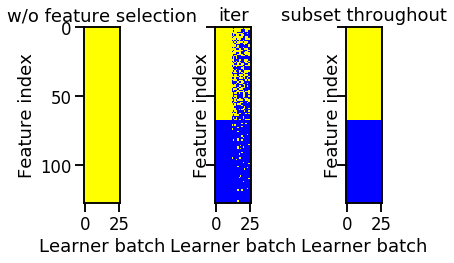

In [15]:
import importlib 
from afs_plotting import plot_feature_selection


fig_feat_activity, ax_feat_activity = plt.subplots(1, 3, 
                                                   sharey = True)



for i, (e, a) in enumerate(zip(exp_data_all,  ax_feat_activity)):
    plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
    
    #only title the exp if there are three exp, right. 
    if len(exp_data_all) == 3: 
        a.set_title(feature_selection_schemes[i])

fig_feat_activity.tight_layout()

In [19]:
# next question I ask,  how many features are being selected, anyway? 
num_features_exp_by_batch = []

for i,e in enumerate(exp_data_all):

    active_set = e['feature_selection']['feat_set']

    num_features_over_batch = np.sum(active_set, axis = 1)
    num_features_exp_by_batch.append(num_features_over_batch.copy())


num_features_exp_by_batch = np.array(num_features_exp_by_batch)

In [21]:
num_features_exp_by_batch

array([[128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128],
       [ 68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  43,
         40,  43,  41,  36,  39,  36,  32,  30,  27,  28,  31,  30,  34],
       [ 68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68]])

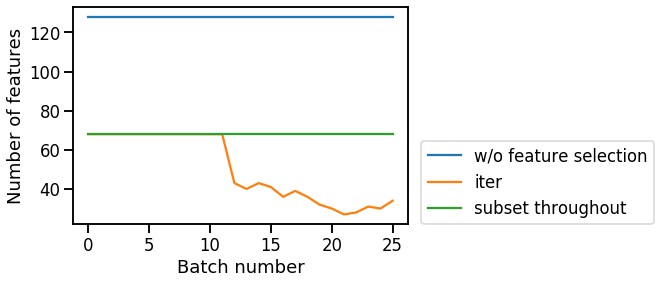

In [27]:
fig_num_features, ax_num_features = plt.subplots()

ax_num_features.plot(num_features_exp_by_batch.T)

ax_num_features.set_xlabel('Batch number')
ax_num_features.set_ylabel('Number of features')
ax_num_features.legend(feature_selection_schemes, loc=(1.04,0))


# Behaviour comparision

## count how many rewards

In [28]:
fps = 60

reward_rate_all = list()
window_time_stamps_all = list()
NUM_EXP = len(exp_data_all)

for i in range(NUM_EXP):

    time_stamps = exp_data_all[i]['events']['time'] / fps
    events = exp_data_all[i]['events']['event']

    (reward_rate, window_time_stamps) = aopy.analysis.calc_running_event_rate(b'REWARD', events, time_stamps, 
                                                                window_size= 120,
                                                                 window_step= 30)
    reward_rate_all.append(reward_rate)
    window_time_stamps_all.append(window_time_stamps)


window_stamps_all = np.array(window_time_stamps_all)
reward_rate_all = np.array(reward_rate_all) 
reward_rate_all = reward_rate_all.reshape((3,-1))
window_stamps_all = window_stamps_all.reshape((3,-1))

In [32]:
reward_rate_all
window_stamps_all

array([[ 60.,  90., 120., 150.],
       [ 60.,  90., 120., 150.],
       [ 60.,  90., 120., 150.]])

Text(0, 0.5, 'Reward rate ')

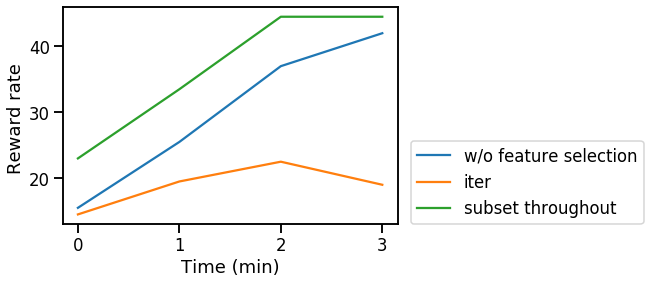

In [37]:
colors = ['blue', 'orange', 'red']

plt.plot(reward_rate_all.T)
plt.legend(feature_selection_schemes, loc=(1.04,0))
plt.xlabel('Time (min)')
plt.ylabel('Reward rate ')


## Trial segments and trajectories

In [9]:
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
TRIAL_END = 239

import functools

def get_all_cursor_trajectories(exp_data_all, start_code = [20], end_codes = [REWARD, HOLD_PENALTY]):
    
    cursor_trajectories_list = list()
        
    for e in exp_data_all:
        (cursor_trajectories, trial_segments, trial_times) = get_cursor_trajectories_from_parsed_data(e, start_code = start_code, end_codes=end_codes)
        cursor_trajectories_list.append(cursor_trajectories)

    
    return cursor_trajectories_list

def get_cursor_trajectories_from_parsed_data(exp_data, start_code = [20], end_codes = [REWARD, HOLD_PENALTY]):
    
    
    events = exp_data['events']
    cursor_kinematics = exp_data['task']['cursor'][:,[0,2]] # cursor (x, z, y) position on each bmi3d cycle

    streamed_code = events['code']
    event_cycles = events['time'] # confusingly, 'time' here refers to cycle count

    trial_segments, trial_times = aopy.preproc.get_trial_segments(streamed_code, event_cycles, start_code,  end_codes)
    trial_segments = np.array(trial_segments)
    trial_indices = [range(t[0], t[1]) for t in trial_times]
    cursor_trajectories = [cursor_kinematics[t] for t in trial_indices]
    
    return (cursor_trajectories, trial_segments, trial_times)

In [10]:
start_codes = range(17, 24)
print(start_codes)

cursor_trajectories_list = get_all_cursor_trajectories(exp_data_all, start_code=start_codes)


range(17, 24)


In [11]:
def calc_trial_times(trial_times):
    """
    for each row, calculate the difference between the last and first elements
    """
    row_index = 1 
    
    return np.apply_along_axis(lambda row: row[-1] - row[0], row_index, trial_times)


#calc_trial_times(trial_times)

In [12]:
# get the unique target positions

from typing import List, Dict
import seaborn as sns


def plot_cursor_trajectories(cursor_trajectories: List, exp_data:Dict, exp_metadata,ax = None):

    fig, ax = plt.subplots(figsize=(10,10))

    trials = exp_data['trials']
    trial_targets = aopy.postproc.get_trial_targets(trials['trial'], trials['target'][:,[0,2]]) # (x, z, y) -> (x, y)
    unique_targets = np.unique(np.concatenate(([t[1] for t in trial_targets], trial_targets[0])), axis=0)


    target_radius =  exp_metadata['target_radius']
    bounds = [-11, 11, -11, 11]
    
    sns.color_palette("dark:salmon_r", as_cmap=True)

    aopy.visualization.plot_trajectories(cursor_trajectories, bounds = bounds, ax = ax)
    aopy.visualization.plot_targets(unique_targets, target_radius, ax = ax)

IndexError: too many indices for array

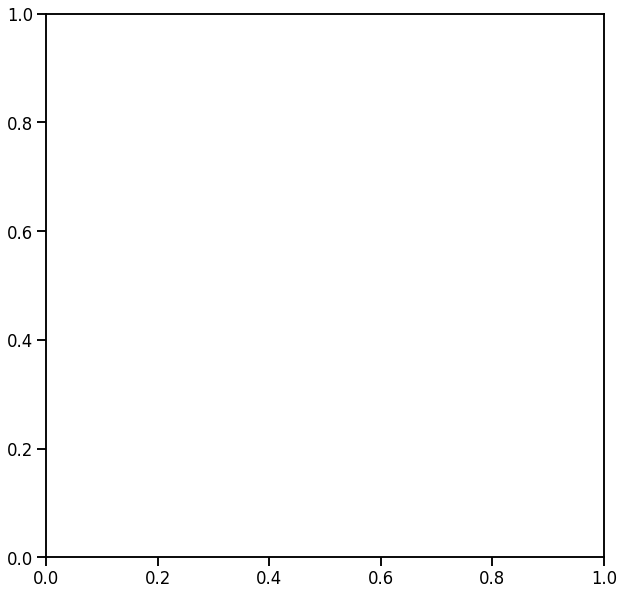

In [13]:
cursor_trajectories_list = np.array(cursor_trajectories_list).reshape(3, -1)



for c in cursor_trajectories_list[:,2]:
    plot_cursor_trajectories(c[:10], exp_data_all[0], exp_metadata_all[0])

# Post data analysis

# Behaviour  analyses

## Trajectory analysis

In [ ]:
def calculate_traj_length(trajectories):
    """
    given a list of trajectories, calculate each trajectory's length
    
    args:
        trajectories[np.ndarray]: number of data points by number of dims
    """
    traj_length = np.empty((len(trajectories)))
    
    for i,t in enumerate(trajectories):
        delta = np.diff(t, axis = 0)
        
        
        delta_length = delta**2
        
        
        delta_sum = np.sum(delta_length, axis = 1) ** (1/2)
        
        delta_sum = np.sum(delta_sum)
        
        traj_length[i] = delta_sum
        
    return traj_length
        
        

def test_calculate_traj_length():
    
    
    #test a line segment length
    cursor_trajectory = np.arange(0,1, 0.1).reshape(-1,1)
    expected_trajectory_length = np.array([0.9])
    calculated_trajectory_length = calculate_traj_length([cursor_trajectory])
    
    np.testing.assert_array_equal(expected_trajectory_length, calculated_trajectory_length)
    
    
test_calculate_traj_length()    

In [ ]:


cursor_length = [calculate_traj_length(t) for t in cursor_trajectories_list]

cursor_length_array = np.asarray(cursor_length).reshape(3, N_RUNS)

colors =  ['b','r', 'y']

print(len(cursor_length))
for t,c in zip(cursor_length_array, colors):
    print(t.shape)
    for l in t:
        plt.plot(l, color = c, alpha = 0.5)

plt.legend(['Full set','Iterative addition', 'Constant subset'])
plt.ylabel('Trial Length (cm)')

plt.xlabel('Trial #')

## Variance analysis

# Kalman filter

## encoder

the job of the encoder is to directly encode intention into firing rates
the direct measure is just pearson correlation coefficients between 
the intentions and the firing rates

## decoder

In [ ]:
exp_data_all[0]['feature_selection'].keys()

In [ ]:
from afs_plotting import plot_prefered_directions

C_mat = exp_data_all[2]['feature_selection']['C_mat']

print(C_mat.shape)



fig, ax = plt.subplots(1,2)

plot_prefered_directions(C_mat[0], ax = ax[0])
plot_prefered_directions(C_mat[-1], ax = ax[1])

In [ ]:
from afs_plotting import plot_prefered_directions

def plot_all_initial_C_mat(exp_data_all, selected_neuron = 'all',debug = True):
    
    """
    just compare initial C mat with the last C_mat
    """
    
    N_EXP = len(exp_data_all)
    
    fig, ax = plt.subplots(2, N_EXP)
    
    for i in range(N_EXP):
        C_mat = exp_data_all[i]['feature_selection']['C_mat']
        plot_prefered_directions(C_mat[0][no_noise_neuron_ind,:], ax = ax[0,i])
        plot_prefered_directions(C_mat[-1][no_noise_neuron_ind,:], ax = ax[1,i])
        

plot_all_initial_C_mat(exp_data_all)


## Decoder compared to the encoder



In [ ]:
exp_data_all[0].keys()

In [ ]:
exp_data_all.shape

In [38]:
import importlib
import convergence_analysis
importlib.reload(convergence_analysis)
from convergence_analysis import calc_cosine_sim_bet_two_matrices, calc_cosine_to_target_matrix

active_angles_list = list()

least_num_updates = 180

for i,e in enumerate(exp_conds):
    feature_selection_data = exp_data_all[i]['feature_selection']
    enc_directions = feature_selection_data['sim_C']
    dec_directions = feature_selection_data['C_mat']
    
    angles_hist = calc_cosine_to_target_matrix(dec_directions, enc_directions)
    
    active_angles = np.mean(angles_hist[:, no_noise_neuron_ind], axis = 1)
    active_angles_list.append(active_angles[:least_num_updates])


KeyError: 'C_mat'

(3, 0)


<Figure size 432x288 with 0 Axes>

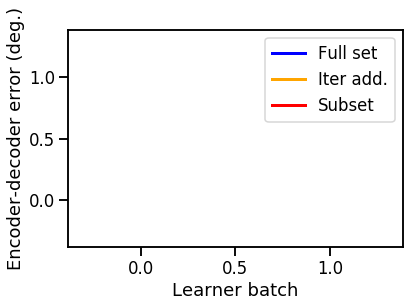

In [15]:

active_angles_list = np.array(active_angles_list) 


active_angles_list_reshape = active_angles_list.reshape((3,N_RUNS,-1))

active_angles_std = np.std(active_angles_list_reshape, axis = 1)
active_angles_mean =  np.mean(active_angles_list_reshape, axis = 1)


plt.figure()

batch_num = np.arange(active_angles_mean.shape[1])


colors = ['blue', 'orange', 'red'] 

print(active_angles_mean.shape)

fig_C, ax_C = plt.subplots()



for i,c in enumerate(colors):

    plt.plot(active_angles_mean[i,:].T, color = c, linewidth = 3)
    plt.fill_between(batch_num,
                    active_angles_mean[i,:] + active_angles_std[i,:],
                    active_angles_mean[i,:] - active_angles_std[i,:],
                    alpha = 0.3, color = c)

plt.xlabel('Learner batch')
plt.ylabel('Encoder-decoder error (deg.)')
plt.legend(['Full set', 'Iter add.', 'Subset'])

## batch update 

In [ ]:
exp_data_all

In [ ]:
len(exp_data_all)

In [17]:
import importlib
import convergence_analysis
importlib.reload(convergence_analysis)
from convergence_analysis import calc_cosine_sim_bet_two_matrices, calc_cosine_to_target_matrix

def train_C_mat_on_batch_data(intended_kin, spike_counts_batch):

    C_hat_list = list()
    
    num_times =  intended_kin.shape[0]
    
    for i  in range(num_times):

        k = intended_kin[i, :,:]
        s = spike_counts_batch[i,:,:]

        C,Q = KalmanFilter.MLE_obs_model(k, s, include_offset=False, drives_obs=[3,5])

        C_hat_list.append(C)



    C_hat_list = np.array(C_hat_list)
    
    return C_hat_list
    

In [18]:
import sympy as sp

clda_log = exp_data_all[0]['bmi3d_clda']
intended_kin = clda_log['intended_kin']
spike_counts_batch = clda_log['spike_counts_batch']
kf_C = clda_log['kf_C']

c_hat_list = train_C_mat_on_batch_data(intended_kin, spike_counts_batch)

NameError: name 'KalmanFilter' is not defined

In [ ]:
c_hat_angles = calc_cosine_to_target_matrix(c_hat_list)

## compare to lasso regularization

In [19]:
from sklearn.linear_model import Lasso, LinearRegression

alpha = 10
max_iteration = 10000

lasso_model = Lasso(alpha, max_iter = max_iteration)
linear_reg_model = LinearRegression()

In [20]:
drive_obs = [3,5]

intended_kin_one_batch = intended_kin[0,drive_obs,:]
spike_counts_one_batch = spike_counts_batch[0,:,:]

lasso_model.fit(intended_kin_one_batch.T, spike_counts_one_batch.T )

Lasso(alpha=10, max_iter=10000)

In [21]:
linear_reg_model.fit(intended_kin_one_batch.T, spike_counts_one_batch.T)

LinearRegression()

In [22]:
# get a series of alphas 

alpha_series = [0, 1, 10, 100] #get a series of alphas

alpha_weights_scan = []

for a in alpha_series:
    lasso_model.set_params(alpha = a)
    lasso_model.fit(intended_kin_one_batch.T, spike_counts_one_batch.T)
    
    alpha_weights_scan.append(lasso_model.coef_.copy())
    
    print(f'finished alpha = {a}')

alpha_weights = np.array(alpha_weights_scan)

finished alpha = 0
finished alpha = 1
finished alpha = 10
finished alpha = 100


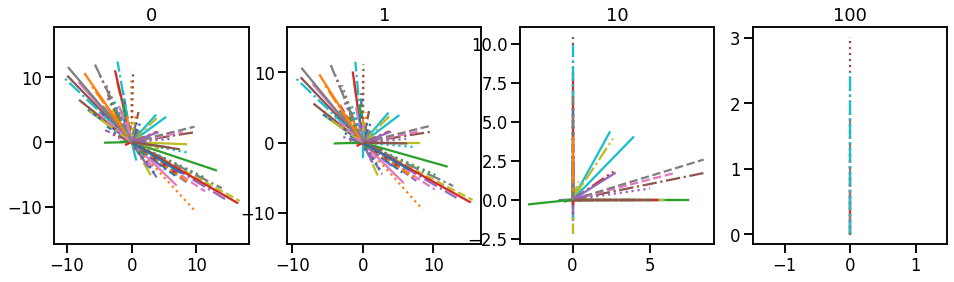

In [23]:
from afs_plotting import plot_prefered_directions

fig, ax = plt.subplots(1, len(alpha_series), figsize = (4 * len(alpha_series), 4))

for a,w,ax_i in zip(alpha_series, alpha_weights_scan, ax):
    plot_prefered_directions(w, ax = ax_i)
    ax_i.set_title(a)


In [24]:
alpha_weights_norm = np.linalg.norm(alpha_weights, axis = 2)

Text(0, 0.5, 'Weight norm')

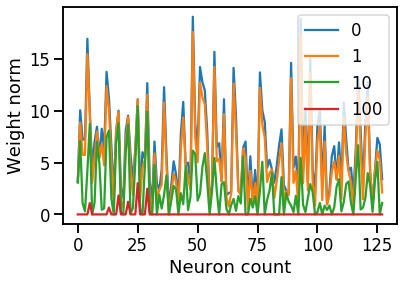

In [25]:
plt.plot(alpha_weights_norm.T)
plt.legend(alpha_series)
plt.xlabel('Neuron count')
plt.ylabel('Weight norm')

In [26]:
# we can then look at lasso path to figure out the smooth coefficients 

from sklearn.linear_model import lasso_path 

eps = 5e-3  # the smaller it is the longer is the path
print("Computing regularization path using the lasso...")
X = intended_kin_one_batch.T
y = spike_counts_one_batch.T
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps)

print(alphas_lasso.shape,min(alphas_lasso), max(alphas_lasso))
print('shape of coefs_lasso', coefs_lasso.shape)

Computing regularization path using the lasso...
(100,) 55.02534879416641 11005.069758833279
shape of coefs_lasso (128, 2, 100)


(100,)

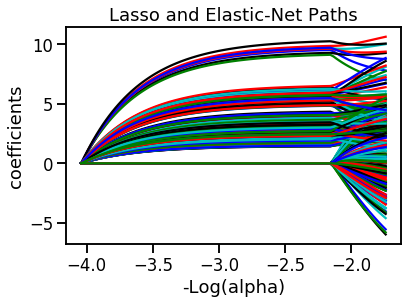

In [27]:

from itertools import cycle

plt.figure(1)
colors = cycle(["b", "r", "g", "c", "k"])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l.T, c=c)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Lasso and Elastic-Net Paths")
plt.axis("tight")

neg_log_alphas_lasso.shape

(128, 100)


(100,)

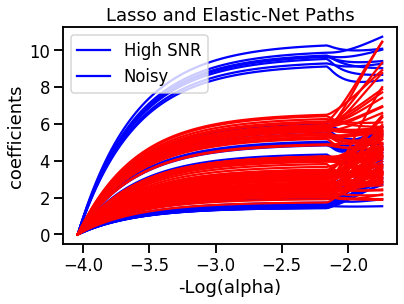

In [28]:
from numpy.linalg import norm

coefs_lasso_norm = norm(coefs_lasso, axis = 1)
print(coefs_lasso_norm.shape)



from itertools import cycle


num_high_snr = 32
num_noise = 96

plt.figure(1)
colors = ['b'] * num_high_snr + ['r'] * num_noise
neg_log_alphas_lasso = -np.log10(alphas_lasso)

for l1_coef, c in zip(coefs_lasso_norm, colors):

    l1 = plt.plot(neg_log_alphas_lasso, l1_coef, c=c)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Lasso and Elastic-Net Paths")
plt.axis("tight")
plt.legend(['High SNR', 'Noisy'])
neg_log_alphas_lasso.shape

there are two issue

In [39]:
lasso_hist = feature_selection_data['lasso_hist']

print(lasso_hist.shape)

(240, 2, 128)


##  examine the lasso_hist coefficients.
the main problem is that it does not converge on the fly
it does not converge,  becasue we did not use the right indices to train. 
this can still happen in real time.

this highlights the issue in real time,  we just cannot randomly trained a lasso regression. 


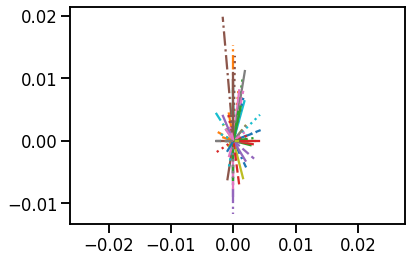

In [41]:
num_batch = 0
plot_prefered_directions(lasso_hist[num_batch, :, :].T)

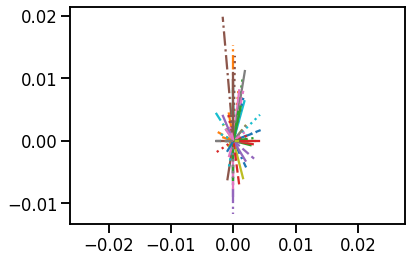

In [43]:
num = -1
plot_prefered_directions(lasso_hist[num_batch,:,:].T)

a quick comparision between the two shows that the observation matrix does not change. 
which basically makes sense, in the sense that 

## looking at K matrix

In [ ]:
NUM_EXP = 3
GLOBAL_FIGURE_VERTICAL_SIZE  = 4

figure_k_matrix, axes_k_matrix = plt.subplots(2,NUM_EXP,
                                          figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * NUM_EXP,
                                                    GLOBAL_FIGURE_VERTICAL_SIZE * 2))
exp_data_all_reshaped = exp_data_all.reshape(3, N_RUNS)


#compare the K matrix before the exp
for i in range(NUM_EXP):
    K_mat = exp_data_all_reshaped[0,i]['feature_selection']['K_mat']
    K = K_mat[1].T

    plot_prefered_directions(K, ax  = axes_k_matrix[0, i], plot_states = [0,2])
    axes_k_matrix[0, i].set_title(exp_conds[i])

#compare to the matrix after the exp
for i in range(3):
    K_mat = exp_data_all[i]['feature_selection']['K_mat']
    
    K = K_mat[-1].T
    plot_prefered_directions(K, ax  = axes_k_matrix[1, i], plot_states = [0,2])
    axes_k_matrix[1,i].set_title(exp_conds[i])
figure_k_matrix.tight_layout()

In [ ]:



def plot_state_bar(K:np.ndarray, ax =  None, fig = fig, state_names = None):
    """
    K [np.array]: a state variable that records the state
    """
    
    num_state, num_var = K.shape
    
    if num_state >= num_var: print(f'Number of states {num_state} is greater than the {num_var} \n is this intended?')
        
    if ax is None: fig, ax = plt.subplots(2, 3, figsize = (12, 8),sharex =  True)
        
    var_pos = np.arange(num_var)
    
    for i in range(3):
        ax[0, i].bar(var_pos, K[i,:])
        ax[1,i].bar(var_pos, K[i + 3,:])
        
        
        
    fig.tight_layout()
    
    return ax


fig, ax = plt.subplots(2,3, figsize = (12,8))


for i in range(len(exp_data_all)):
    K_mat = exp_data_all[i]['feature_selection']['K_mat']
    K = K_mat[-1]

    plot_state_bar(abs(K), ax = ax, fig = fig)

In [ ]:
active_feat_set = feature_selection_data['feat_set']
active_feat_set_last = active_feat_set[0]
active_angles_list = list()

least_num_updates = 180

for i,e in enumerate(exp_conds):
    feature_selection_data = exp_data_all[i]['feature_selection']
    enc_directions = feature_selection_data['sim_C']
    dec_directions = feature_selection_data['K_mat']

    dec_directions = np.moveaxis(dec_directions, 2,1)   
    

    angles_hist = calc_cosine_to_target_matrix(dec_directions,
                                               enc_directions)
    
    active_angles = np.mean(angles_hist[:, no_noise_neuron_ind], axis = 1)
    

    active_angles_list.append(active_angles[:least_num_updates])


In [ ]:

active_angles_list = np.array(active_angles_list)
active_angles_list = active_angles_list.reshape((3,N_RUNS,-1))

active_angles_mean = np.mean(active_angles_list, axis = 1)
active_angles_std = np.std(active_angles_list, axis = 1)

colors = ['blue', 'orange', 'red'] 

print(active_angles_mean.shape)

fig_C, ax_C = plt.subplots()



for i,c in enumerate(colors):

    plt.plot(active_angles_mean[i,:].T, color = c, linewidth = 3)
    plt.fill_between(batch_num,
                    active_angles_mean[i,:] + active_angles_std[i,:],
                    active_angles_mean[i,:] - active_angles_std[i,:],
                    alpha = 0.3, color = c)


plt.xlabel('Learner batch number')
plt.ylabel('Encoder-decoder error (deg.)')
plt.legend(['Full set', 'Iter add.', 'Subset'])

In [ ]:


fig_C, ax_C = plt.subplots()


colors = ['blue', 'orange'] 

batch_num = np.arange(least_num_updates) * 10

print(active_angles_mean.shape)

for i,c in enumerate(colors):

    plt.plot(batch_num, active_angles_mean[i,:].T, color = c, linewidth = 3)
    plt.fill_between(batch_num,
                    active_angles_mean[i,:] + active_angles_std[i,:],
                    active_angles_mean[i,:] - active_angles_std[i,:],
                    alpha = 0.3, color = c)

plt.title('Initial training on subset enables faster decoder convergence')
plt.xlabel('Training time (s)')
plt.ylabel('Encoder-decoder error (deg.)', fontsize = 14)
plt.legend(['Full set', 'Iter add.'])

In [ ]:
# examine the features after the first update.

def find_K_gain(index:int, update_period: float, fps = 60):
    """
    find the latest Kalman gain
    """
    update_frame_count = int(update_period * fps)
    
    return int(index // update_frame_count)
    
def test_find_K_gain():
    
    assert 0 == find_K_gain(598, 10, 60)
    assert 1 == find_K_gain(1198, 10, 60)

test_find_K_gain()

In [ ]:
update_time = 600

spike_counts = exp_data_all[0]['bmi3d_task']['spike_counts']
spike_counts = np.squeeze(spike_counts)

spike_counts_single_time = spike_counts[update_time, :]

target_state  = exp_data_all[0]['bmi3d_task']['target_state']
target_state_time = target_state[update_time, :]


num_K = find_K_gain(update_time, update_period = 10)
K_mat_time = K_mat[num_K]

feature_state_update = K_mat_time @  np.diag(spike_counts_single_time)


target_state_time_rep = np.tile(target_state_time, len(spike_counts_single_time))


useful_update = feature_state_update * target_state_time_rep
useful_update = np.sum(useful_update, axis = 0)


plt.plot(useful_update)


In [ ]:
intended_kin = exp_data_all[0]['bmi3d_clda']['intended_kin']

spike_counts_batch = exp_data_all[0]['bmi3d_clda']['spike_counts_batch']
spike_counts_batch =  np.swapaxes(spike_counts_batch, 2, 1)

intended_kin = np.swapaxes(intended_kin, 2, 1)

spike_counts_batch.shape

In [ ]:
print(intended_kin.shape)

intended_kin_one = intended_kin[1, 1, :]
print(intended_kin_one)

## Q mat

In [ ]:
feature_selection_data.keys()

In [ ]:
fig_Q, axes_Q = plt.subplots(1,2, sharey = True)

num_noises = 1

from afs_plotting import get_cmap
import matplotlib as mpl

cmap_q = get_cmap(num_noises)

cmap_q_1 = get_cmap(num_noises, mpl.cm.Oranges)

cmap_q_2 = get_cmap(num_noises, mpl.cm.Reds)

for i in range(num_noises):
    
    for j in range(3):


        Q_list = np.array(exp_data_all[j]["feature_selection"]['Q_diag'])



        Q_diag_no_noise = np.mean(Q_list[:, no_noise_neuron_ind], axis = 1)

        Q_diag_noise = np.mean(Q_list[:, noise_neuron_ind], axis = 1)



        axes_Q[0].plot(Q_diag_noise)

        axes_Q[1].plot(Q_diag_no_noise)

    

axes_Q[0].set_xlabel('Time (s)')

axes_Q[1].set_xlabel('Time (s)')



axes_Q[0].set_title('Low SNR neurons')

axes_Q[1].set_title('High SNR neurons')



# Feature analysis

In [ ]:
decoder_state = exp_data_all[0]['bmi3d_task']['decoder_state']
target_state = exp_data_all[0]['bmi3d_task']['target_state']
spike_counts = exp_data_all[0]['bmi3d_task']['spike_counts']


print(decoder_state.shape)
print(target_state.shape)
print(spike_counts.shape)

spike_counts = exp_data_all[0]['bmi3d_task'].dtype

In [ ]:
exp_data_all[0]['bmi3d_task'].dtype

In [ ]:
exp_data_all[0]['feature_selection']['K_mat'].shape

In [ ]:
exp_data_all[0]['bmi3d_task']['update_bmi']

In [ ]:
np.argwhere((exp_data_all[0]['bmi3d_task']['update_bmi']))

## examine used C mat

In [ ]:
GLOBAL_FIGURE_VERTICAL_SIZE  =  10

fig_compr_means, axes_compr_means = plt.subplots(1, N_TYPES_OF_NEURONS,
                                                figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * N_TYPES_OF_NEURONS,
                                                          GLOBAL_FIGURE_VERTICAL_SIZE),
                                                sharey = True)
selected_feature_set = no_noise_neuron_list

for i,a in enumerate(axes_compr_means):

    type_neuron_list = neuron_type_bool_list[i]
    
    for C in C_mat_all:


        the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(C, 
                                                                                                         target_C = enc_directions)


        selected_neurons = np.logical_and(selected_feature_set, type_neuron_list)

        selected_mean = np.mean(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        std = np.std(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        
        line = a.plot(selected_mean)
        
        x_data = np.arange((selected_mean).shape[0])
        
        
        a.fill_between(x_data ,selected_mean - std, selected_mean + std, alpha = 0.1 )
        a.legend(exp_conds)
        
handles, labels = a.get_legend_handles_labels()
fig_compr_means.legend(handles, labels, loc='lower center')
plt.show()
#axes_compr_means.set_title('Means of the high SNR weight trajectory')